## Mozilla CV - MFCC
### ResNet50

In [1]:
# !pip install tensorflow pandas keras matplotlib numpy scikit-learn opencv-python

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import keras
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import Sequence
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


n_epoch = 10
batch_size = 32
image_shape = (374, 500, 3)
base_dir = "/content/drive/MyDrive/ml-project/mozilla-cv/mfcc/mfcc-mcv-train"

In [4]:
#@title Batch Generator
class DataGenerator(Sequence):

    def __init__(self, X, y, base_dir, batch_size, n_class, shuffle=False):
        self.X = X
        self.y = y
        self.n_class = n_class
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        assert len(self.X) == len(self.y)
        return int(np.ceil(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        X_batch = self.X[index*self.batch_size : (index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size : (index+1)*self.batch_size]

        X = self.__data_generation(X_batch)
        y = keras.utils.to_categorical(y_batch, num_classes=self.n_class)
        return X, y

    def __data_generation(self, X_img):
        X = []
        for file in X_img:
            t = cv2.imread(f"{self.base_dir}/{file}", cv2.COLOR_BGR2RGB)
            X.append(t)
        return np.asarray(X)

In [5]:
#@title Model Creation
resnet50 = tensorflow.keras.applications.resnet50.ResNet50(weights=None, input_shape=image_shape, classes=2)

model = Sequential()
model.add(resnet50)

model.build(input_shape=image_shape)
model.summary()

adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2)                 23591810  
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
#@title Data Splitting
df = pd.read_csv("/content/drive/MyDrive/ml-project/mozilla-cv/mfcc/mfcc-mcv-train.csv")
print("init df size:", len(df))

X = df["imgname"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Dataset and Image Loaded")
print("X_train:", len(X_train), "\tX_test:",  len(X_test))
print("y_train:", len(y_train), "\ty_test:",  len(y_test))

init df size: 4422
Dataset and Image Loaded
X_train: 3537 	X_test: 885
y_train: 3537 	y_test: 885


In [7]:
#@title Data Generation
train_gen = DataGenerator(X_train, y_train, base_dir=base_dir, n_class=2, batch_size=batch_size)
test_gen  = DataGenerator(X_test,  y_test,  base_dir=base_dir, n_class=2, batch_size=batch_size)

In [8]:
#@title Model Training
for i in range(n_epoch):
  print("Epoch:", i)
  model.fit(train_gen, verbose=1)
  model.save(f"/content/drive/MyDrive/ml-project/mozilla-cv/mfcc/mfcc_resnet50_mcv_cp_{i}", save_format="h5")

Epoch: 0
111/111 [==============================] - 2998s 27s/step - loss: 0.6737 - accuracy: 0.6189
Epoch: 1
111/111 [==============================] - 58s 519ms/step - loss: 0.5791 - accuracy: 0.7147
Epoch: 2
111/111 [==============================] - 58s 520ms/step - loss: 0.4756 - accuracy: 0.7823
Epoch: 3
111/111 [==============================] - 57s 509ms/step - loss: 0.4440 - accuracy: 0.8001
Epoch: 4
111/111 [==============================] - 57s 516ms/step - loss: 0.3881 - accuracy: 0.8267
Epoch: 5
111/111 [==============================] - 57s 511ms/step - loss: 0.3369 - accuracy: 0.8527
Epoch: 6
111/111 [==============================] - 58s 518ms/step - loss: 0.3137 - accuracy: 0.8725
Epoch: 7
111/111 [==============================] - 57s 509ms/step - loss: 0.2817 - accuracy: 0.8790
Epoch: 8
111/111 [==============================] - 57s 510ms/step - loss: 0.2487 - accuracy: 0.8999
Epoch: 9
111/111 [==============================] - 58s 518ms/step - loss: 0.2348 - accurac

28/28 [==============================] - 760s 28s/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       430
           1       0.85      0.02      0.05       455

    accuracy                           0.50       885
   macro avg       0.67      0.51      0.35       885
weighted avg       0.67      0.50      0.34       885



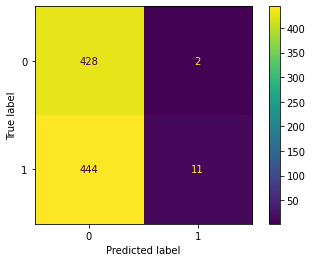

In [9]:
#@title Model Prediction
y_pred = model.predict(test_gen)
y_pred_arg = np.argmax(y_pred, axis=1)

report = classification_report(y_true=y_test, y_pred=y_pred_arg)
print(report)

conf_mat = confusion_matrix(y_test, y_pred_arg)
conf_dis = ConfusionMatrixDisplay(conf_mat)
conf_dis.plot()
plt.show()